# Decision Trees for Classification

## The goal of this notebook is:
- exploring and preprocessing a dataset with many columns and imbalanced classes!
- why we need to drop columns with many nulls
- how to target encode categorical features with more 2 classes!
- create a baseline pipline
- exhaustive grid search for hyperparameter tuning

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [2]:
#load the dataset 
df = pd.read_csv("./dev/input/License_Data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85895 entries, 0 to 85894
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ID                                 85895 non-null  object 
 1   LICENSE ID                         85895 non-null  int64  
 2   ACCOUNT NUMBER                     85895 non-null  int64  
 3   SITE NUMBER                        85895 non-null  int64  
 4   LEGAL NAME                         85895 non-null  object 
 5   DOING BUSINESS AS NAME             85894 non-null  object 
 6   ADDRESS                            85895 non-null  object 
 7   CITY                               85895 non-null  object 
 8   STATE                              85895 non-null  object 
 9   ZIP CODE                           85864 non-null  object 
 10  WARD                               36194 non-null  float64
 11  PRECINCT                           29194 non-null  flo

In [4]:
df.head(3).T

,0,1,2
ID,35342-20020816,1358463-20051116,1980233-20090722
LICENSE ID,1256593,1639294,1980233
ACCOUNT NUMBER,32811,262311,345008
SITE NUMBER,1,29,1
LEGAL NAME,CARMEN CAHUE,"ISLA TROPICAL, INC.",DJS REMODELING
DOING BUSINESS AS NAME,CLAUDIA'S BRIDAL SHOP,ISLA TROPICAL,"DJS REMODELING, INC."
ADDRESS,2625 S CENTRAL PARK AVE 1,2825 W MONTROSE AVE,1605 CLAVEY RD 1
CITY,CHICAGO,CHICAGO,HIGHLAND
STATE,IL,IL,IL
ZIP CODE,60623.0,60618,60035


## Data Exploration

### Categorical

In [5]:
# changing the name of Columns for convenience 
new_names=[col_name.replace(" ","_").lower() for col_name in df.columns ]
df.columns=new_names

<Axes: xlabel='license_status'>

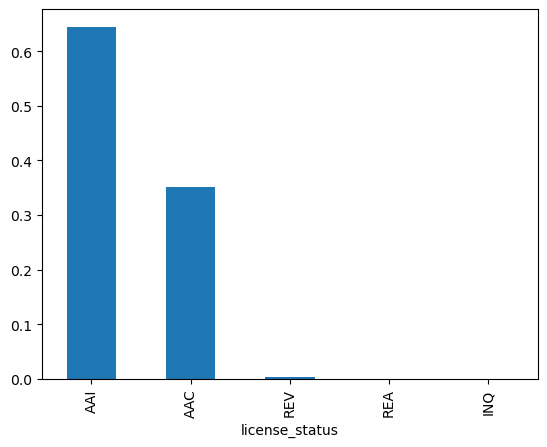

In [6]:
df.license_status.value_counts(normalize=True).plot.bar()


## "license_status" is the dependet variable and we have a severe class imbalance between classes!
- __A dummy model__ without training could have about 65% accuracy, if it only predict for all inputs "AAI"-Label! 

In [7]:
# column zip_code is numerical, but somehow recognized as object , so convert it back 
zip_numeric=pd.to_numeric(df.zip_code,errors='coerce')
index_to_drop=df[zip_numeric.isnull()].index
df.zip_code=zip_numeric #set the numeric values
df.drop(index_to_drop,inplace=True) # drop rows with null value

In [8]:
# selecting categorical and numerical features
target=['license_status']
features= [col_name for col_name in df.columns if col_name not in target]
#features
numerical_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df[features].select_dtypes(include=['object', 'bool']).columns
print(f'nr of categorical: {len(categorical_ix)} and nummerical: {len(numerical_ix)} variables')

nr of categorical: 19 and nummerical: 12 variables


In [9]:
# Exploring categorical values
cat_df=pd.DataFrame(columns=['var_name','nr of null rows','nr of unique values','population of values'])
for i in range(len(categorical_ix)):
    nr_null=df[categorical_ix[i]].isnull().sum()
    nr_unique_v=df[categorical_ix[i]].nunique()
    count_unique_v=df[categorical_ix[i]].value_counts(normalize=True).round(3).to_list()
    cat_df.loc[i]=[categorical_ix[i]] + [nr_null] + [nr_unique_v] + [count_unique_v]
    #print(count_unique_v if nr_unique_v < 5 else '')

In [10]:
cat_df

,var_name,nr of null rows,nr of unique values,population of values
0,id,0,85842,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,legal_name,0,38725,"[0.008, 0.002, 0.001, 0.001, 0.001, 0.001, 0.0..."
2,doing_business_as_name,1,41665,"[0.007, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0..."
3,address,0,42120,"[0.006, 0.002, 0.001, 0.001, 0.001, 0.001, 0.0..."
4,city,0,1217,"[0.428, 0.015, 0.014, 0.012, 0.009, 0.009, 0.0..."
5,state,0,52,"[0.938, 0.02, 0.006, 0.004, 0.004, 0.003, 0.00..."
6,ward_precinct,49667,2383,"[0.04, 0.031, 0.023, 0.013, 0.013, 0.008, 0.00..."
7,license_description,0,106,"[0.583, 0.124, 0.033, 0.033, 0.027, 0.023, 0.0..."
8,application_type,0,5,"[0.711, 0.272, 0.016, 0.0, 0.0]"
9,application_created_date,64613,2899,"[0.008, 0.006, 0.006, 0.003, 0.002, 0.002, 0.0..."


## Why we need to drop columns with many  Null/NaN values?
- Reducing Model Complexity and Saving Resources: Dropping columns with many Null/NaN values indeed helps simplify the model by reducing the number of features it needs to consider. This, in turn, saves computational resources and can improve the efficiency of the model's training and inference processes.

- Preventing Data Leakage: When a column is predominantly filled with Null/NaN values for a specific class or outcome, the model may inadvertently learn to associate this column with that class. This can lead to data leakage, where the model makes predictions based on irrelevant or biased information, rather than genuine patterns in the data. By dropping such columns, we mitigate the risk of data leakage and ensure that the model learns from meaningful features rather than spurious correlations
- Permuting will not be efficient enough because the null values comprise more than half of all rows. As a result, permuting the data would likely not significantly alter the distribution of null values within the dataset, making it an ineffective strategy for handling missing values

In [11]:
# example
pd.crosstab(df.license_status_change_date.isnull(),df.license_status)

license_status,AAC,AAI,INQ,REA,REV
license_status_change_date,,,,,
False,30189,0,2,3,290
True,0,55358,0,0,0


__As__ we see the model could only look for Null values in "license_status_change_date" columns</br>
and correctly predicts the licence_status as AAI ! 

to drop (not helpful or to many missing values):
- location -> because , location = latitude + longitiude
- id, legal_name, address,doing_business_as_name, application_created_date,license_status_change_date,ward_precinct

In [12]:
cols_to_drop=['id','location','legal_name','doing_business_as_name',
              'address','ward_precinct','application_created_date',
              'license_status_change_date','ward_precinct']

In [13]:
df.drop(cols_to_drop,axis=1,inplace=True)

In [14]:
# selecting categorical and numerical features
target=['license_status']
features= [col_name for col_name in df.columns if col_name not in target]
#features
numerical_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df[features].select_dtypes(include=['object', 'bool']).columns
print(f'nr of categorical: {len(categorical_ix)} and nummerical: {len(numerical_ix)} variables')

nr of categorical: 11 and nummerical: 12 variables


### Numerical

In [15]:
# Exploring categorical values
num_df=pd.DataFrame(columns=['var_name','nr of null rows','nr of unique values'])
for i in range(len(numerical_ix)):
    nr_null=df[numerical_ix[i]].isnull().sum()
    nr_unique_v=df[numerical_ix[i]].nunique()
    #count_unique_v=df[numerical_ix[i]].value_counts(normalize=True).round(3).to_list()
    num_df.loc[i]=[numerical_ix[i]] + [nr_null] + [nr_unique_v] 
    #print(count_unique_v if nr_unique_v < 5 else '')

In [16]:
num_df

,var_name,nr of null rows,nr of unique values
0,license_id,0,85842
1,account_number,0,38877
2,site_number,0,177
3,zip_code,0,1703
4,ward,49668,50
5,precinct,56649,76
6,police_district,53960,28
7,license_code,0,106
8,license_number,1,49740
9,ssa,76396,53


In [17]:
# nummeric cols to drop
cols_to_drop=['license_id','account_number','ward','precinct','police_district','police_district',
              'ssa','latitude','longitude']
df.drop(cols_to_drop,axis=1,inplace=True)

In [18]:
# selecting categorical and numerical features
target=['license_status']
features= [col_name for col_name in df.columns if col_name not in target]
#features
numerical_ix = df[features].select_dtypes(include=['int64', 'float64']).columns
categorical_ix = df[features].select_dtypes(include=['object', 'bool']).columns
print(f'nr of categorical: {len(categorical_ix)} and nummerical: {len(numerical_ix)} variables')

nr of categorical: 11 and nummerical: 4 variables


In [19]:
categorical_ix

Index(['city', 'state', 'license_description', 'application_type',
       'application_requirements_complete', 'payment_date',
       'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued'],
      dtype='object')

In [20]:
numerical_ix

Index(['site_number', 'zip_code', 'license_code', 'license_number'], dtype='object')

## To note:
__In__  a normal case, we would split the dataset to train and test and after that only do resampling on training part</br>
but class 2 and 3 have only 5 samples together!</br>
So it makes no sense to keep these classes,because the model could after all not create useful predictions for these classes!

In [21]:
df.license_status.value_counts()

license_status
AAI    55358
AAC    30189
REV      290
REA        3
INQ        2
Name: count, dtype: int64

In [22]:
# drop the minority classes
index_to_drop=df[(df.license_status == 'REA') | (df.license_status == 'INQ') ].index
df.drop(index_to_drop,axis=0,inplace=True)

## Transformation:
- encoding the categorical variables
- creating new features from time-based categorical features(dates)
- scale the numerical and handle the outliers

__Target__ Encoding of Catergorical Features:
Some categorical features like " city,state,license_description,application_type " needs to be encoded! 
because of multiclass classification, we need to:
- step 1: one hot code the target
- step 2: target code every categorical feature with responding one-hot columns of labels

In [23]:
#Step1 
# One hotencoding of Target parameter 
from sklearn.preprocessing import OneHotEncoder,TargetEncoder,LabelEncoder
from sklearn.preprocessing import TargetEncoder

enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
y_onehot=enc.fit_transform(df[target]);
y_onehot.columns

Index(['license_status_AAC', 'license_status_AAI', 'license_status_REV'], dtype='object')

In [24]:
#Step2
# target encoding of categroical features
cat_cols_to_target=['city', 'state', 'license_description', 'application_type']
te=TargetEncoder(target_type='auto',smooth=0).set_output(transform='pandas')# encoder
for col_name in y_onehot.columns:
    tmp=te.fit_transform(df[cat_cols_to_target],y_onehot[col_name])
    tmp.columns=[ str(col_name).split("_")[-1]+ "_"+str(c) for c in tmp.columns]
    df= pd.concat([df,tmp],axis=1)

In [25]:
df.columns

Index(['site_number', 'city', 'state', 'zip_code', 'license_code',
       'license_description', 'license_number', 'application_type',
       'application_requirements_complete', 'payment_date',
       'conditional_approval', 'license_term_start_date',
       'license_term_expiration_date', 'license_approved_for_issuance',
       'date_issued', 'license_status', 'AAC_city', 'AAC_state',
       'AAC_license_description', 'AAC_application_type', 'AAI_city',
       'AAI_state', 'AAI_license_description', 'AAI_application_type',
       'REV_city', 'REV_state', 'REV_license_description',
       'REV_application_type'],
      dtype='object')

Now we have all categorical columns except the columns with dates encoded! 

In [26]:
# Label encoding of "license_status" from string to numbers 1,2,3,4,5 for every class
le = LabelEncoder()
df['target_encoded']=le.fit_transform(df.license_status)

In [27]:
# encode conditional_approval to numeric values 
df['conditional_approval']=df.conditional_approval.apply(lambda val : 1 if val=='Y' else 0)

In [28]:
# now we will drop all encoded and unnecessary columns
to_drop=['city', 'state','license_description', 'application_type','license_status',]
df.drop(to_drop,inplace=True,axis=1)

#### Exploration of dated-based Feature/Columns

In [29]:
# now creating new features from time based-features / Dates 
time_based_columns=['application_requirements_complete','payment_date','license_term_start_date',
                   'license_term_expiration_date','license_approved_for_issuance','date_issued']


In [30]:
df[time_based_columns].head().T

,0,1,2,3,4
application_requirements_complete,2002-06-28T00:00:00,2005-09-22T00:00:00,2009-07-22T00:00:00,2004-02-10T00:00:00,2008-03-24T00:00:00
payment_date,2002-08-21T00:00:00,2005-11-03T00:00:00,2009-07-22T00:00:00,2004-02-10T00:00:00,2008-06-04T00:00:00
license_term_start_date,2002-08-16T00:00:00,2005-11-16T00:00:00,2009-07-22T00:00:00,2004-02-11T00:00:00,2008-05-16T00:00:00
license_term_expiration_date,2003-08-15T00:00:00,2006-11-15T00:00:00,2011-07-15T00:00:00,2005-02-15T00:00:00,2010-05-15T00:00:00
license_approved_for_issuance,2002-08-21T00:00:00,2006-04-05T00:00:00,2009-07-22T00:00:00,2004-02-10T00:00:00,2008-06-04T00:00:00
date_issued,2006-04-11T00:00:00,2006-06-12T00:00:00,2009-07-22T00:00:00,2004-02-11T00:00:00,2008-06-05T00:00:00


#### Feature engineering form Date-based columns:
In the original from are the columns with dates not useful, so we will extract potentaly usful </br>
numbers from them in from of days between:
- start to expiration
- payed to start
- requiremets completed  to payed
- approved for issuance to issued

In [31]:
df['start_expiration']=(pd.to_datetime(df.license_term_start_date) - pd.to_datetime(df.license_term_expiration_date)).dt.days.abs()
df['payed_start']=(pd.to_datetime(df.payment_date) - pd.to_datetime(df.license_term_start_date)).dt.days.abs()
df['compelted_start']=(pd.to_datetime(df.license_term_start_date) - pd.to_datetime(df.application_requirements_complete)).dt.days.abs()
df['approved_issued']=(pd.to_datetime(df.license_approved_for_issuance) - pd.to_datetime(df.date_issued)).dt.days.abs()
# drop the orginal dated based columns
df.drop(time_based_columns,inplace=True,axis=1)

In [32]:
df.columns

Index(['site_number', 'zip_code', 'license_code', 'license_number',
       'conditional_approval', 'AAC_city', 'AAC_state',
       'AAC_license_description', 'AAC_application_type', 'AAI_city',
       'AAI_state', 'AAI_license_description', 'AAI_application_type',
       'REV_city', 'REV_state', 'REV_license_description',
       'REV_application_type', 'target_encoded', 'start_expiration',
       'payed_start', 'compelted_start', 'approved_issued'],
      dtype='object')

target_encoded
1    55358
0    30189
2      290
Name: count, dtype: int64


<Axes: xlabel='target_encoded'>

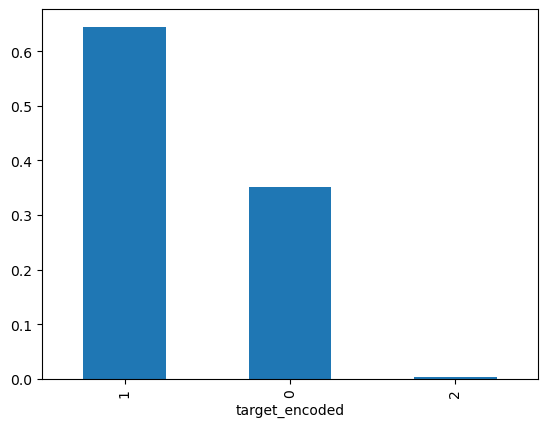

In [33]:
# imbalance in classes
print(df.target_encoded.value_counts())
df.target_encoded.value_counts(normalize=True).plot.bar()

### Now we will create a function to do all preprocessing done until now ! 

In [34]:
def preprocess_dataset():
    """
    function to do preprocessing and feature extraction on dataset

    Return:
        df : pandas DataFrame as cleaned Dataset 
    """
    df = pd.read_csv("./dev/input/License_Data.csv")
    new_names=[col_name.replace(" ","_").lower() for col_name in df.columns ]
    df.columns=new_names
    #------------------------
    # column zip_code is numerical, but somehow recognized as object , so convert it back 
    zip_numeric=pd.to_numeric(df.zip_code,errors='coerce')
    index_to_drop=df[zip_numeric.isnull()].index
    df.zip_code=zip_numeric #set the numeric values
    df.drop(index_to_drop,inplace=True) # drop rows with null value
    
    #---------------------------------------------------------------
    cols_to_drop=['id','location','legal_name','doing_business_as_name',
              'address','ward_precinct','application_created_date',
              'license_status_change_date','ward_precinct']
    df.drop(cols_to_drop,axis=1,inplace=True)
    
    #------------------------------------------------------------------
    # nummeric cols to drop
    cols_to_drop=['license_id','account_number','ward','precinct','police_district',
                  'police_district','ssa','latitude','longitude']
    df.drop(cols_to_drop,axis=1,inplace=True)
    
    #---------------------------------------------------------
    # drop extrem minority classes!
    index_to_drop=df[(df.license_status == 'REA') | (df.license_status == 'INQ') ].index
    df.drop(index_to_drop,axis=0,inplace=True)
    # encoding
    from sklearn.preprocessing import OneHotEncoder,TargetEncoder,LabelEncoder
    target=['license_status']
    enc = OneHotEncoder(handle_unknown='ignore',sparse_output=False).set_output(transform='pandas')
    y_onehot=enc.fit_transform(df[target]);
    # target encoding of categroical features
    cat_cols_to_target=['city', 'state', 'license_description', 'application_type']
    te=TargetEncoder(target_type='auto',smooth=0).set_output(transform='pandas')# encoder
    for col_name in y_onehot.columns:
        tmp=te.fit_transform(df[cat_cols_to_target],y_onehot[col_name])
        tmp.columns=[ str(col_name).split("_")[-1]+ "_"+str(c) for c in tmp.columns]
        df= pd.concat([df,tmp],axis=1)
    
    #-------------------------------------------------------------
    # Label encoding of "license_status" from string to numbers 1,2,3,4,5 for every class
    le = LabelEncoder()
    df['target_encoded']=le.fit_transform(df[target])
    # encode conditional_approval to numeric values 
    df['conditional_approval']=df.conditional_approval.apply(lambda val : 1 if val=='Y' else 0)
    # now we will drop all encoded and unnecessary columns
    to_drop=['city', 'state','license_description', 'application_type','license_status',]
    df.drop(to_drop,inplace=True,axis=1)
    
    #----------------------------------------------------------
    # now creating new features from time based-features / Dates 
    time_based_columns=['application_requirements_complete','payment_date','license_term_start_date',
                   'license_term_expiration_date','license_approved_for_issuance','date_issued']
    df['start_expiration']=(pd.to_datetime(df.license_term_start_date) - pd.to_datetime(df.license_term_expiration_date)).dt.days.abs()
    df['payed_start']=(pd.to_datetime(df.payment_date) - pd.to_datetime(df.license_term_start_date)).dt.days.abs()
    df['compelted_start']=(pd.to_datetime(df.license_term_start_date) - pd.to_datetime(df.application_requirements_complete)).dt.days.abs()
    df['approved_issued']=(pd.to_datetime(df.license_approved_for_issuance) - pd.to_datetime(df.date_issued)).dt.days.abs()
    # drop the orginal dated based columns
    df.drop(time_based_columns,inplace=True,axis=1)

    #----------------------------------------------------------
    return df

## Creating a baseline model 
- in first step we will a random forest model as our baseline model for comparision
### To note:
- Because a rondom forest model is not __sensitive to ourliers or normal distributed or scaled data__ </br>
we don't need these stepes in our pipline!

### Metrics to evaluate the performance of the model:
- accuracy / f1-micro: overall performance of the model
- macro avg: sum of f1-score for each class and divided by number of classes
- weighted: like macro avg but with weighting the f1-score based on numbers of samples(support) in test dataset, more samples-> more weights on f1-score

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix
#-------------------------------
from sklearn.model_selection import GridSearchCV,KFold
from collections import Counter
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

In [45]:
# creating dataset for train and test
dataset=preprocess_dataset()
dataset.target_encoded.value_counts()
test_size=0.2
y=dataset.target_encoded.to_frame()
df_train, df_test = train_test_split(dataset, test_size=test_size, random_state=0, stratify=y)
# train 
X_train=df_train.drop(['target_encoded'],axis=1)
y_train=df_train['target_encoded']
# test
X_test=df_test.drop(['target_encoded'],axis=1)
y_test=df_test['target_encoded']

In [46]:
dataset.target_encoded.value_counts()

target_encoded
1    55358
0    30189
2      290
Name: count, dtype: int64

In [47]:
#------------------------------------------------
# definiton of over and under sampling portion for every class
classes_population=Counter(df_train.target_encoded)
r_m_classes=0.6 # percentage to reduce the majority classes
class_1=int(classes_population[1] * r_m_classes)
class_2= int(class_1 * 0.1) # 
rus_dic={1:class_1} # majority class
ros_dic={2:class_2} # minority class

# creating a pipline for training and testing
over = RandomOverSampler(sampling_strategy=ros_dic,random_state=0)
under = RandomUnderSampler(sampling_strategy=rus_dic,random_state=0)
model = DecisionTreeClassifier(random_state=0)
imp_mean = SimpleImputer(strategy='mean')
steps = [('i',imp_mean),('u', under),('o', over),('model',model)]
pipe= Pipeline(steps=steps)


In [48]:
class_1,class_0,class_2

(26571, 24151, 2657)

In [49]:
# Cross Validate the model for ajusting the expections and reginizing Over and under fitting !
scoring = ['f1_macro']
results=cross_validate(pipe,X_train,y_train,scoring=scoring,cv=5)
res_df=pd.DataFrame(results)

In [50]:
res_df

,fit_time,score_time,test_f1_macro
0,0.528600,0.008929,0.601083
1,0.507063,0.009411,0.598500
2,0.550796,0.009809,0.643088
3,0.557106,0.009990,0.632839
4,0.540182,0.009327,0.631795


__Now__ we now , what to expect from a model (f1-Score about 0.6 - 0.64 ) !  

In [51]:
# create a model and train and test it 
pipe.fit(X_train,y_train);
y_preds=pipe.predict(X_test)
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      6038
           1       0.91      0.85      0.88     11072
           2       0.27      0.28      0.27        58

    accuracy                           0.84     17168
   macro avg       0.64      0.65      0.64     17168
weighted avg       0.85      0.84      0.84     17168



## Comparing the results with a different model ( hyperparameter tuning with GridSearch)

In [52]:
classes_population=Counter(df_train.target_encoded)
r_m_classes=0.6 # percentage to reduce the majority class
seed=73
class_1=int(classes_population[1] * r_m_classes)
class_2= int(class_1 * 0.1) # 
rus_dic={1:class_1} # majority class
ros_dic={2:class_2} # minority class
#------------------------
over = SMOTE(sampling_strategy=ros_dic,random_state=seed)
under = RandomUnderSampler(sampling_strategy=rus_dic,random_state=seed)
model = DecisionTreeClassifier(random_state=seed)
imp_simple = SimpleImputer()
steps = [('i',imp_simple),('u', under),('o', over),('model',model)]
pipe= Pipeline(steps=steps)

In [54]:
cv = KFold(n_splits=3, shuffle=True, random_state=0)
imputing_strategy=['mean','median','most_frequent']
scoring = ['accuracy','f1_macro']
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
class_weights=[{0:1,1:1,2:1}]
parameters = dict(i__strategy=imputing_strategy,model__criterion=criterion,
                  model__max_depth=max_depth,model__class_weight=class_weights)
clf_GS = GridSearchCV(pipe, parameters,scoring=scoring,return_train_score=False,
                      cv=cv,refit='f1_macro',error_score='raise',)
gs_results=clf_GS.fit(X_train,y_train);

In [55]:
res_df=pd.DataFrame(gs_results.cv_results_)
res_df[(res_df.rank_test_accuracy==1) | (res_df.rank_test_f1_macro==1)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_i__strategy,param_model__class_weight,param_model__criterion,param_model__max_depth,params,split0_test_accuracy,...,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_f1_macro,split1_test_f1_macro,split2_test_f1_macro,mean_test_f1_macro,std_test_f1_macro,rank_test_f1_macro
11,0.364166,0.003542,0.012524,0.000259,mean,"{0: 1, 1: 1, 2: 1}",entropy,12,"{'i__strategy': 'mean', 'model__class_weight':...",0.883137,...,0.881209,0.882320,0.000814,1,0.679287,0.649268,0.661563,0.663373,0.012322,12
15,0.312261,0.003604,0.011896,0.000092,median,"{0: 1, 1: 1, 2: 1}",gini,8,"{'i__strategy': 'median', 'model__class_weight...",0.876322,...,0.873345,0.874252,0.001467,17,0.694117,0.648431,0.670100,0.670883,0.018659,1


In [56]:
gs_results.best_params_

{'i__strategy': 'median',
 'model__class_weight': {0: 1, 1: 1, 2: 1},
 'model__criterion': 'gini',
 'model__max_depth': 8}

In [57]:
gs_results.best_score_

0.6708828158060368

In [58]:
# Test the model
best_model=gs_results.best_estimator_ # best model
predictions=best_model.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      6038
           1       0.95      0.85      0.90     11072
           2       0.20      0.34      0.25        58

    accuracy                           0.87     17168
   macro avg       0.64      0.70      0.66     17168
weighted avg       0.88      0.87      0.87     17168



As we see, the model performes slightly better than the baseline model. </br>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


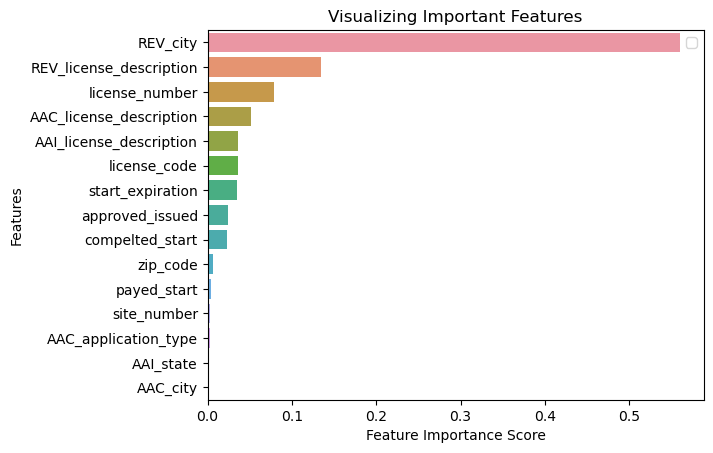

In [59]:
# 4. element of pipline is the model 
best_model[3].feature_importances_
feature_importance = pd.DataFrame([X_train.columns, best_model[3].feature_importances_])
feature_importance = feature_importance.T.sort_values(by = 1, ascending=False)[:15]
sns.barplot(x=feature_importance[1], y=feature_importance[0])
# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [79]:
pd.crosstab(df['target_encoded'],df['REV_city'])

REV_city,0.000000,0.003378,0.003379,0.004739,0.004785,0.004831,0.004854,0.007854,0.007863,0.007874,0.007876,0.007895
target_encoded,,,,,,,,,,,,
0,4236,76,41,5,4,5,6,5164,5139,5161,5162,5190
1,44313,167,102,40,43,44,44,2077,2135,2154,2161,2078
2,1,0,0,0,0,0,0,58,58,58,58,57
